In [364]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
from astropy.table import Table
from scipy.interpolate import interp1d
import sys
sys.path.append('../analysis/')
import read_mist_models
import analysis_utils

highlight = np.array((66, 135, 245))/255
red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
color_cycle = [red, blue, yellow, green, darkblue]
pl.rc('image', cmap='plasma')

In [365]:
import os
data = pd.DataFrame()
for file in os.listdir('../output/txtoutput'):
    print("reading file: {0}".format(file))
    data = data.append(pd.read_csv('../output/txtoutput/'+file, skiprows=1, delimiter='\t'))

reading file: out8.dat
reading file: out18.dat
reading file: out16.dat
reading file: out112.dat
reading file: out17.dat
reading file: out15.dat
reading file: out111.dat
reading file: out14.dat
reading file: out13.dat
reading file: out102.dat
reading file: out12.dat
reading file: out3.dat
reading file: out2.dat
reading file: out0.dat
reading file: out1.dat
reading file: out5.dat
reading file: out4.dat
reading file: out6.dat
reading file: out7.dat


In [366]:
k2dr2 = Table.read('../analysis/k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic')
df = df.drop_duplicates(subset='epic_number')

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [367]:
import imp
imp.reload(analysis_utils)
ms = analysis_utils.selectms(
    df, 
    '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd', 
    bp_rp_range=(0.0, 5.0),
    g_rp_range=(0.0, 5.0),
    width=(-0.6, 0.6)
)

Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd


In [368]:
good_P = ms['P_mean'] / ms['P_sd'] > 15
good_P = good_P & (ms['P_mean'] < 32)
good_P = good_P & ((ms['logamp_mean'] - ms['logS0_mean']) > np.log(1e-3))
tau1 = ms['P_mean']*np.sqrt(np.exp(ms['logQ0_mean'])**2 - 1)
tau2 = ms['P_mean']*np.sqrt((np.exp(ms['logQ0_mean'])+ np.exp(ms['logdQ_mean']))**2 - 1)
color = np.log(tau1 + tau2)

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [369]:
from astropy.io import fits 
file = '/Users/tgordon/research/round/round/data/gaia_clusters.fit'
with fits.open(file) as data:
    clusters = Table.read(file, format='fits')
    clusters = clusters.to_pandas()

df = pd.merge(clusters, ms, left_on='Source', right_on='source_id')

ngc6811 = df[df['Cluster'] == b'NGC_6811']
praesepe = df[df['Cluster'] == b'NGC_2632']
praesepe.drop_duplicates(subset='source_id');

In [370]:
ngc6811 = np.loadtxt("curtis2019.txt", usecols=[0, 1, 2, 3, 4, 5, 6, 8, 9])
ngc6811 = Table(ngc6811).to_pandas()

ru147 = Table.read('ruprecht147.fits', format='fits')

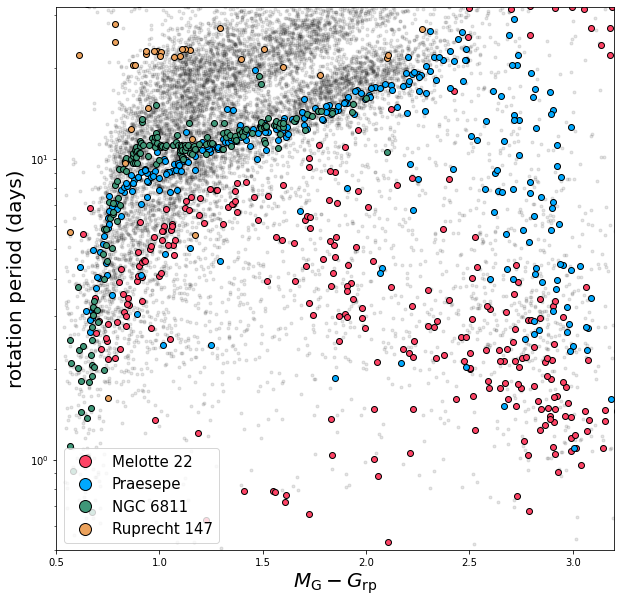

In [371]:
pl.figure(figsize=(10, 10))
pl.semilogy(ms[good_P]['bp_rp'], ms[good_P]['P_mean'], 'k.', alpha=0.1)
pl.yscale('log')
pl.xlim(0.5, 3.2)
pl.ylim(0.5, 32)
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
pl.xlabel(r'$M_\mathrm{G} - G_\mathrm{rp}$', fontsize=20)
pl.ylabel('rotation period (days)', fontsize=20)

labels = ['Melotte 22', 'Praesepe', 'NGC 6811', 'Ruprecht 147']
for i, cluster in enumerate([b'Melotte_22', b'NGC_2632']):
    members = df[df['Cluster'] == cluster]
    members.drop_duplicates(subset='source_id')
    good = members['P_mean'] / members['P_sd'] > 10
    pl.semilogy(members[good]['bp_rp'], members[good]['P_mean'], 'o', markersize=6, markeredgecolor='k', 
                markeredgewidth=1, color=color_cycle[i], alpha=1, label=labels[i])
pl.semilogy(ngc6811['col4'], ngc6811['col7'], 'o', markersize=6, markeredgecolor='k', 
                markeredgewidth=1, color=color_cycle[3], alpha=1, label=labels[2])
pl.semilogy(ru147['(BP-RP)0'], ru147['Per'], 'o', markersize=6, markeredgecolor='k', 
                markeredgewidth=1, color=color_cycle[2], alpha=1, label=labels[3])
legend = pl.legend(fontsize=15, loc='lower left')
[lh._legmarker.set_markersize(12) for lh in legend.legendHandles]
pl.savefig('/Users/tgordon/Desktop/cpd_clusters.pdf')

In [448]:
import imp
imp.reload(analysis_utils)
import analysis_utils as utils
mass_all, mask_all = utils.bp_rp_to_mass(ms[good_P]['bp_rp'], '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd')

Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd


Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd
Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd
Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd
Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd


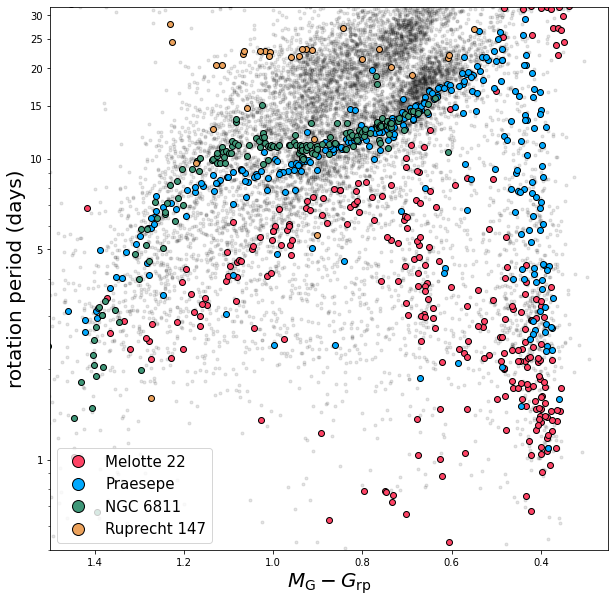

In [452]:
pl.figure(figsize=(10, 10))
pl.semilogy(mass_all, ms[good_P & mask_all]['P_mean'], 'k.', alpha=0.1)
pl.yscale('log')
pl.xlim(0.5, 3.2)
pl.ylim(0.5, 32)
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
pl.xlabel(r'$M_\mathrm{G} - G_\mathrm{rp}$', fontsize=20)
pl.ylabel('rotation period (days)', fontsize=20)

labels = ['Melotte 22', 'Praesepe', 'NGC 6811', 'Ruprecht 147']
for i, cluster in enumerate([b'Melotte_22', b'NGC_2632']):
    members = df[df['Cluster'] == cluster]
    members.drop_duplicates(subset='source_id')
    good = members['P_mean'] / members['P_sd'] > 10
    mass, mask = utils.bp_rp_to_mass(members[good]['bp_rp'], 
                                     '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd')
    pl.semilogy(mass, members[good & mask]['P_mean'], 'o', markersize=6, markeredgecolor='k', 
                markeredgewidth=1, color=color_cycle[i], alpha=1, label=labels[i])
mass, mask = utils.bp_rp_to_mass(ngc6811['col4'], 
                                     '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd')
pl.semilogy(mass, ngc6811['col7'][mask], 'o', markersize=6, markeredgecolor='k', 
                markeredgewidth=1, color=color_cycle[3], alpha=1, label=labels[2])
mass, mask = utils.bp_rp_to_mass(ru147['(BP-RP)0'], 
                                     '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd')
pl.semilogy(mass, ru147['Per'][mask], 'o', markersize=6, markeredgecolor='k', 
                markeredgewidth=1, color=color_cycle[2], alpha=1, label=labels[3])
legend = pl.legend(fontsize=15, loc='lower left')
[lh._legmarker.set_markersize(12) for lh in legend.legendHandles]
pl.xlim(1.5, 0.25)
#pl.ylim(0.5, 32)
pl.gca().yaxis.set_major_formatter(pl.ScalarFormatter())
pl.gca().set_yticks([1, 5, 10, 15, 20, 25, 30])
pl.gca().set_yticklabels([1, 5, 10, 15, 20, 25, 30]);
pl.savefig('/Users/tgordon/Desktop/cpd_clusters_mass.pdf')